# Notebook exercise - working with spectral data (or patterns)

Experimental characterisation methods like NMR and IR commonly produce datasets in the form of 1-dimensional (or sometimes 2D) spectra. For simple 1D NMR experiments, for example, the spectrum is usually output in the form of intensity vs. chemical shift $\delta$ in ppm.


#### Analysing spectra

Determining information about the structure of molecules in the sample usually starts with extracting information about the peaks present in the NMR spectrum. The peak information can then be interpreted to provide specific information about the composition and connectivity of the molecule.

In general, fitting peaks with a function that models the shape serves several purposes including: to gain some fundamental understanding of the nature of the data (e.g. does the method and/or specific instrument produce a particular peak shape); if the peaks are modelled well, the information on their centres, amplitudes can be more precise.


#### Aim of this notebook exercise


To get an overview how 1D spectral data can be analysed to acquire information about the peaks - positions of the centres, widths, intensities, etc. - we will look at a simple NMR spectrum and practise some pandas, matplotlib and scipy skills along the way.

*Processing spectra involves modelling data.* This exercise also gives us a chance to look more closely at how a model is being applied to the data and see some of the considerations and issues you should be aware of as you work with even simple data problems.



In [1]:
# import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

The <sup>13</sup>C NMR spectrum of ethanol is stored as a csv file (`13C_EtOH.csv`) in the data directory `data`.

It is a good idea to check the contents of a file before you try to load it using Python. 

This is particularly the case with data files to get an idea of the structure of the file, whether it has any header lines that you might want to skip over or if the column names are present, for example.

:::{tip}
You can run shell (terminal) command from a Jupyter notebook. More info here: https://tinyurl.com/2yv37k2x
:::

In [2]:
# Use the `head` shell command to look at the first few lines of the file 

!head data/13C_EtOH.csv

ppm,intensity
0.0,-0.13155779056191633
0.010001428775539363,0.013802319695433997
0.020002857551078727,-0.06619407291030063
0.030004286326618092,-0.03602621041588254
0.04000571510215745,-0.056128503825357536
0.050007143877696815,0.10561769096847173
0.060008572653236184,0.020263292838484902
0.07001000142877555,0.023343731486136766
0.0800114302043149,0.03142774821198622


In [3]:
# Read the NMR spectrum from the csv into a pandas dataframe

nmr_spec = pd.read_csv("data/13C_EtOH.csv")
nmr_spec

,ppm,intensity
0,0.000000,-0.131558
1,0.010001,0.013802
2,0.020003,-0.066194
3,0.030004,-0.036026
4,0.040006,-0.056129
...,...,...
6995,69.959994,0.003248
6996,69.969996,-0.026781
6997,69.979997,-0.053444
6998,69.989999,-0.022786


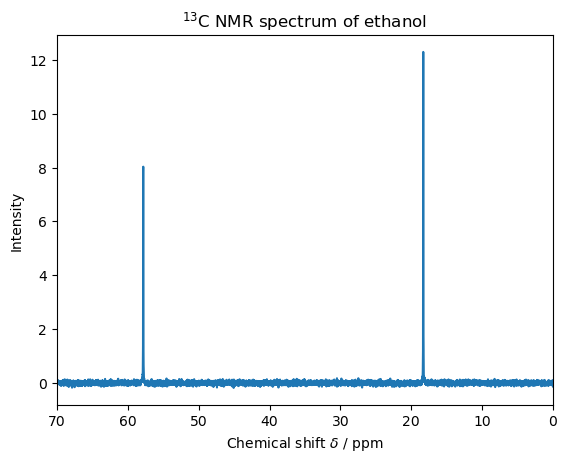

In [4]:
# Plot the spectrum
fig, ax = plt.subplots()
ax.plot(nmr_spec["ppm"], nmr_spec["intensity"])

plt.xlabel("Chemical shift $\\delta$ / ppm")
plt.ylabel("Intensity")

plt.xlim((70, 0))
plt.title(r"$\mathregular{^{13}C}$ NMR spectrum of ethanol")
plt.show()

The code above uses matplotlib's `pyplot.plot` to graph the spectrum. This might be how you have mostly seen plotting in matplotlib so far.

Pandas also provides a [`plot` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) on its DataFrame and Series objects that offers a convenient way to [visualise data](https://pandas.pydata.org/docs/user_guide/visualization.html) using matplotlib (it uses matplotlib by default but can be changed to others, e.g. plotly).

For example, it will pick up axis labels from the DataFrame columns, but you can also modify if preferred.

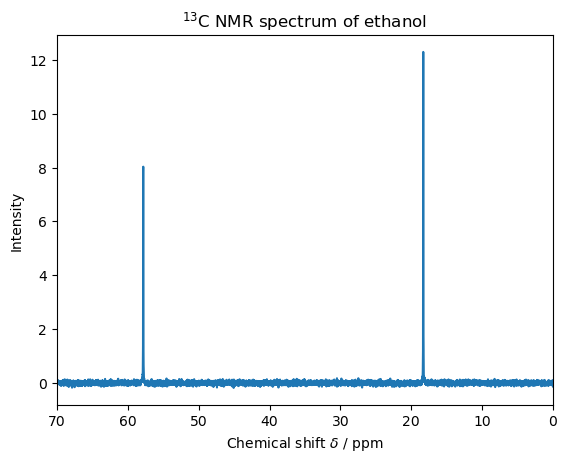

In [5]:
# Try it yourself:
# Plot an equivalent graph of the NMR spectrum using DataFrame.plot()

nmr_spec.plot(x="ppm", 
              y="intensity",
              xlabel="Chemical shift $\\delta$ / ppm",
              ylabel="Intensity",
              legend=False)

plt.xlim((70, 0))
plt.title(r"$\mathregular{^{13}C}$ NMR spectrum of ethanol")
plt.show()

Decomposing the spectrum into a set of peaks can sometimes be incorporated into the processing that is done by the experimental acquisition software. There are also various Python packages dedicated to different types of spectroscopic data which can facilitate integration into automated data processing pipelines.

To get a picture of what is going in this process, we can use some of the general methods available in scipy's signal processing and optimisation subpackages to analyse the peaks in our simple NMR spectrum.

</br>

### Peak processing in scipy

In CHEM501, you used some of the functions available in [SciPy](https://docs.scipy.org/doc/scipy/index.html)'s [`optimize`](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#optimization-scipy-optimize) subpackage that can be used to fit population distributions by modelling the population distribution function (PDF) as a curve that follows a Gaussian (or Lorentzian) function.

We can use the same process to fit peaks in experimentally measured datasets like NMR spectra.

The peaks in NMR spectra are usually described as Lorentzian functions, but sometimes Gaussian or pseudo-Voigt (a mixture of Gaussian and Lorentzian) shapes are used. For our <sup>13</sup>C NMR spectrum, we can define the Lorentzian and Gaussian functions:

[**Lorentzian**](https://mathworld.wolfram.com/LorentzianFunction.html)

$$y = \frac{A}{\pi} \frac{W/2}{(x-x_0)^2+(W/2)^2}$$

where *A* is the amplitude of the peak, *W* is the full width at half maximum (FWHM) and *x*<sub>0</sub> is value of *x* at the peak centre.

</br>

[**Gaussian**](https://mathworld.wolfram.com/GaussianFunction.html)

$$y = A \cdot \frac{1}{\sigma\sqrt{2\pi}}\;\exp(-\frac{(x-x_0)^2}{2\sigma^2})$$
<!---$$y = f(x) = A \cdot \frac{1}{\sigma\sqrt{2\pi}}\;e^{-\frac{(x-x_0)^2}{2\sigma^2}}$$--->

Here, *x*<sub>0</sub> rather than $\mu$ is used to represent the centre of the peak (for the normal PDF, $\mu$ was the mean of the  distribution) and $\sigma$ and the FWHM, *W*, of the peak are related by:
$$
W = \sigma\sqrt{8\:\ln2}
$$ 



In [6]:
# These functions will calculate a peak using a Gaussian or Lorentzian function 
# as defined above.

def gaussian(x_array, ampl, centre, width):
    """Generate a signal with a Gaussian shape."""
    sigma = width/np.sqrt(8*np.log(2))
    return ampl*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x_array-centre)**2/(2*sigma**2))

def lorentzian(x_array, ampl, centre, width):
    """Generate a signal with a Lorentzian shape."""
    h_width = width/2
    return ampl/np.pi * h_width/((x_array-centre)**2 + h_width**2)

Before using the functions to try fitting the NMR peaks, we can look at an example of what the two peak shapes look like by simulating a peak generated by the two functions and plotting them:

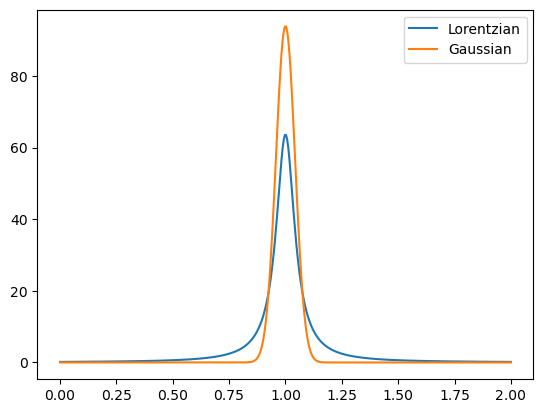

In [7]:
# Write some code here to generate a peak of each type centred at 1, with a width of 
# 0.1 and amplitude of 10.
# Tip: the numpy linspace method makes it straightforward to generate an equally-spaced 
# array of numbers for the x-axis data.

x = np.linspace(0, 2, 400)
y_lor = lorentzian(x, 10, 1, 0.1)
y_gauss = gaussian(x, 10, 1, 0.1)

# Once you have the two peaks, plot them on the same set of axes to compare them.

plt.plot(x, y_lor, label="Lorentzian")
plt.plot(x, y_gauss, label="Gaussian")
plt.legend()
plt.show()

We now know that the functions can model the shape of Lorentzian and Gaussian peaks. So we should be able to use them to try to fit the peaks in the NMR spectrum. The fitting process optimises the model's parameters to obtain a calculated spectrum that is as close as possible to the experimentally observed data.

Both the Lorentzian and Gaussian models have three parameters that can be varied to modify the peak shape: the amplitude, position of the peak's centre and the peak's width. Depending on the type of measurement, all three can provide information about the analyte.

We will use [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit the peaks in the spectrum. It uses [non-linear least squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) to fit a function - in this case the Lorentzian we defined - to a set of data.  

:::{seealso}
Here is a basic intro to [Least Squares Optimisation](least_squares_opt).
:::

</br></br>

#### Peak finding - getting initial model parameters

You might remember that the optimisation needs a set of initial guesses for the parameters to fit the curve. For one or two peaks, that is easily done by hand, but we can use scipy's signal processing [`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) to do this in Python.

The `find_peaks` function locates local maxima in the 1D array it is passed by comparing data points with neighbouring values.

Try running the function on the intensity data of the NMR spectrum.

In [8]:
# Pass the NMR intensities to the find_peaks function and check the results (take a look at the `find_peaks` docs to see what it returns). 
# Note the shape of the array storing the indices of the peaks in the intensity array.

peak_idx, peak_info = find_peaks(nmr_spec["intensity"])
peak_idx

array([   1,    3,    5, ..., 6989, 6994, 6998], shape=(2320,))

`array([   1,    3,    5, ..., 6989, 6994, 6998], shape=(2320,))`

Running the peak finding on the intensities without providing any extra constraints results in `find_peaks` locating over 2000 peaks in the spectrum, rather than the two we see when we plot the spectrum. The additional "peaks" are weak intensity local maxima. The vast majority (all but two) are points that are higher intensity than their surroundings, but not significantly higher than the backgground noise.

`find_peaks` can also take other arguments that filter the peaks it finds based on the properties of the peaks. The information it returns will also depend on the arguments passed.
Check the [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) and modify the call to `find_peaks` to filter the peaks and get the information required as initial guesses for the Lorentzian peaks.

In [9]:
# Modify the call to `find_peaks` below to filter the peaks to just the two real resonances.
# Your call should include parameters so that the function returns enough peak information to get initial values for 
# peak amplitude, centre and width.

peak_idx, peak_info = find_peaks(nmr_spec["intensity"])

# uncomment the line below and run the cell to load the complete code
# %load code_snips/find_peaks_filter.txt
intensity_threshold = nmr_spec["intensity"].max() / 10
width_threshold = 1
peak_idx, peak_info = find_peaks(nmr_spec["intensity"], height=intensity_threshold, width=width_threshold)

print(peak_idx)
peak_info

[1831 5782]


{'peak_heights': array([12.29852933,  8.03475347]),
 'prominences': array([12.45146209,  8.20926082]),
 'left_bases': array([ 816, 4507]),
 'right_bases': array([4507, 6787]),
 'widths': array([2.7734915 , 3.57548198]),
 'width_heights': array([6.07279829, 3.93012305]),
 'left_ips': array([1829.77789912, 5780.65854805]),
 'right_ips': array([1832.55139061, 5784.23403004])}

`find_peaks` is not aware of the data along the x-axis, i.e. the chemical shift, there is still some work to pull out the peak centres and the width of the peaks in ppm - at the moment, the widths are given in terms of the number of data points.


In [10]:
# Use the indices of the peaks to work out the peak centres in ppm and add them to the peak_info dictionary with the key "centres".

# Your code here...

peak_info["centres"] = nmr_spec.iloc[peak_idx]["ppm"].to_numpy()

# uncomment the line below and run the cell to load some code to do this
# %load code_snips/peak_centres_ppm.txt


In [11]:
# The widths are currently expressed in terms of number of data points, i.e. " 'widths': array([2.7734915 , 3.57548198]) " 
# means the FWHM of the first peak is the distance between 2.77 points, which assumes they are evenly spaced.
# Work out the widths in ppm. Update the widths in the peak_info dictionary to these values.
# Hint: You can calculate the distance between adjacent rows in a pandas Series using the diff() method.


# Your code here...

step_size = abs(nmr_spec["ppm"].diff().mean())
peak_info["widths"] = peak_info["widths"] * step_size


# uncomment the line below and run the cell to load some code to do this
# %load code_snips/widths_ppm.txt


In [12]:
peak_info["centres"] = nmr_spec.iloc[peak_idx]["ppm"].to_numpy()
step_size = abs(nmr_spec["ppm"].diff().mean())
peak_info["widths"] = peak_info["widths"] * step_size


In [13]:
# Check the peak information
peak_info

{'peak_heights': array([12.29852933,  8.03475347]),
 'prominences': array([12.45146209,  8.20926082]),
 'left_bases': array([ 816, 4507]),
 'right_bases': array([4507, 6787]),
 'widths': array([0.00027743, 0.00035765]),
 'width_heights': array([6.07279829, 3.93012305]),
 'left_ips': array([1829.77789912, 5780.65854805]),
 'right_ips': array([1832.55139061, 5784.23403004]),
 'centres': array([18.31261609, 57.82826118])}

In [14]:
# Tidy up the peak information

peak_info = {key: val for key, val in peak_info.items() if key in ["peak_heights", "widths", "centres"]}

OK! Finally, let's try fitting the Lorentzian model to the NMR peaks.

</br>

#### Peak fitting - optimising the model to get precise peak information

Now you are ready to run the least squares optimisation to fit the curves to the peaks in the spectrum.

For this simple spectrum, the peaks are well separated so can be fitted separately and the baseline is very low and flat. Check the [`curve_fit` docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) if you need a reminder of how to call the function, passing in the information from the peak_info dictionary as the initial values for the parameters.

One thing to note: The amplitude of the fitted curve will be the integrated intensity - the area under the peak. You can estimate the initial area as that of a rectangle of *height = peak height* and *width = peak width*.

In [15]:
# Run curve fit for each of the peaks in the NMR spectrum and store the output in the lists popt_list and pcov_list
sigma = np.zeros(len(nmr_spec["intensity"])) + nmr_spec["intensity"].std()

popt_list = []
pcov_list = []

for pk in range(len(peak_idx)):
    popt, pcov = curve_fit(lorentzian, 
                           xdata=nmr_spec["ppm"], 
                           ydata=nmr_spec["intensity"], 
                           p0=[peak_info["peak_heights"][pk]*peak_info["widths"][pk],
                               peak_info["centres"][pk], 
                               peak_info["widths"][pk] ],
                           sigma=sigma)
    popt_list.append(popt)
    pcov_list.append(pcov)


# uncomment the line below and run the cell to load some code to do this
# %load code_snips/run_curve_fits.txt


display(popt_list, pcov_list)



[array([ 0.49901399, 18.31409528,  0.0254867 ]),
 array([4.24273805e-01, 5.78328400e+01, 3.07236948e-02])]

[array([[ 4.59522411e-05, -6.25822998e-08,  2.26433795e-06],
        [-6.25822998e-08,  3.29202619e-08, -8.70331796e-09],
        [ 2.26433795e-06, -8.70331796e-09,  2.26203637e-07]]),
 array([[ 9.25174819e-05, -2.23473965e-08,  6.87880162e-06],
        [-2.23473965e-08,  1.15216091e-07, -4.08920167e-09],
        [ 6.87880162e-06, -4.08920167e-09,  1.00796369e-06]])]

#### Assessing the fit

Check the optimised parameters of the fitted Lorentzian peaks stored in `popt_list`. These will be `[amplitude, centre, width]` for each peak. 

Take another look at the spectrum. Do these values look reasonable? It might be difficult to tell with the areas, but
remember the rectangular approximation.

The covariance matrix for the fitted functions are in `pcov_list`. The diagonal elements are the variances of the parameters and these can be used to estimate the errors (uncertainties) on the parameters (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) for info).

</br>

In [16]:
# Calculate the 1-standard deviation errors for each of the parameters of the peaks. Report the parameter values and the associated errors.

errors = [np.sqrt(np.diag(pcov)) for pcov in pcov_list]


def report_peak_fit(popt, perr):
    """Print peak function parameters and 1-sigma errors"""
    report = (f"Amplitude: {popt[0]:.3f} +/- {perr[0]:.3f}\n" 
              f"Centre: {popt[1]:.4f} +/- {perr[1]:.4f}\n"
              f"Width: {popt[2]:.4f} +/- {perr[2]:.4f}\n")

    print(report)

for i, pk in enumerate(popt_list):
    print(f"Peak {i+1}")
    report_peak_fit(pk, errors[i])


Peak 1
Amplitude: 0.499 +/- 0.007
Centre: 18.3141 +/- 0.0002
Width: 0.0255 +/- 0.0005

Peak 2
Amplitude: 0.424 +/- 0.010
Centre: 57.8328 +/- 0.0003
Width: 0.0307 +/- 0.0010



We can also overlay a spectrum calculated from the optimised peak parameters to see if the fitted peaks look reasonable by eye.

In [17]:
# This function simulates a spectrum using the specified peak shape function and a set of parameters passed as a dictionary.
from simulate import simulate_spectrum

In [18]:
def collate_fitted_peak_parameters(popt):
    """ Make a dictionary of peak parameters """

    parameters = ["ampl", "centre", "width"]
    return dict(zip(parameters, popt))

fitted_peaks = [collate_fitted_peak_parameters(popt) for popt in popt_list] # assemble a list of dictionaries for peak parameters

lor_spec_x, lor_spec_y = simulate_spectrum(lorentzian, nmr_spec["ppm"], fitted_peaks)



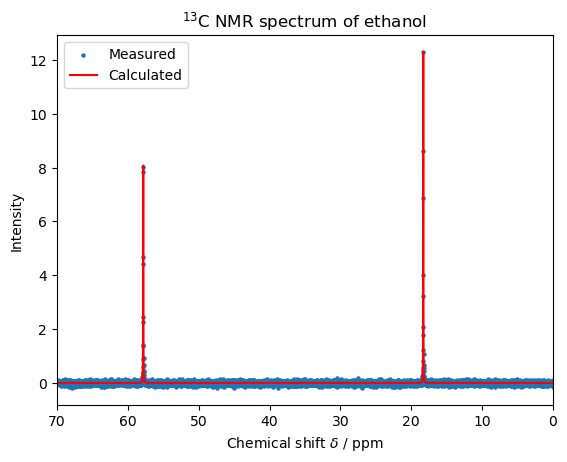

In [19]:
# y_sigma = nmr_spec["intensity"].std()
# y_errors = [y_sigma for y in nmr_spec["intensity"]]

nmr_spec.plot(x="ppm", 
              y="intensity",
              xlabel="Chemical shift $\\delta$ / ppm",
              ylabel="Intensity",
              kind="scatter",
              marker=".",
              label="Measured")

plt.plot(lor_spec_x, lor_spec_y, color="red", label="Calculated")

plt.legend()
plt.xlim((70, 0))
plt.title(r"$\mathregular{^{13}C}$ NMR spectrum of ethanol")
plt.show()

Does this look like a good fit? Try changing the x-limits to check the fit of the peaks more closely.

</br>

#### Performance metrics

We can also use a variety of metrics to assess how well the modelled spectrum fits the experimental data. 

$R$<sup>2</sup> (coefficient of determination) is a statistical measure of how well the model explains the variability of the dependent variable (here, the intensity). Its form is quite intuitive and it is defined as follows:

$$R^2 = 1 - \frac{SSR}{SST}$$

where:  
- **SSR (Sum of Squared Residuals)**: also called the residual sum of squares (**RSS**), is the quantity minimised by least square. It measures the total squared differences between the observed values and the predicted values from the model.  

  $$SSR = \sum (y_i - \hat{y}_i)^2$$

- **SST (Total Sum of Squares)**: measures the total variability in the observed data (without any model), based on the mean $\bar{y}$:

  $$SST = \sum (y_i - \bar{y})^2$$

- If the model fits perfectly, $ SSR = 0 $ and $ R^2 = 1 $, meaning all variability in the data is explained by the model.  
- If the model is no better than simply using the mean $ \bar{y} $, then $ SSR = SST $ and $ R^2 = 0 $.  
- If the model is worse than using the mean (e.g., a bad fit), $ R^2 $ can be negative.

In least squares fitting, reducing SSR improves the model fit and increases $ R^2 $, so a good fit has a high $ R^2 $ close to 1.

We could calculate $R$<sup>2</sup> manually (code in cell below), but scikit-learn's [`metrics` package](https://scikit-learn.org/stable/api/sklearn.metrics.html) makes it straightforward to calculate many measures of model performance.


</br>


In [20]:
# To calculate r^2:

# residuals = lor_spec_y - nmr_spec["intensity"]
# squared_residuals = residuals ** 2
# SSR = squared_residuals.sum()
# SST = ((nmr_spec["intensity"] - nmr_spec["intensity"].mean())**2).sum()
# r2 = 1-(SSR/SST)
# print(r2)


In [21]:
from sklearn.metrics import r2_score

In [22]:
r2 = r2_score(nmr_spec["intensity"], lor_spec_y)
r2

0.9654169899527978

### **Key Points Summary:**

- **Real-World Data Modeling**: In many areas of chemistry (e.g., NMR, IR spectroscopy), fitting models to experimental data is crucial for extracting meaningful information, such as peak positions and intensities.

- **Peak Fitting**: Fitting peaks to a model function helps extract more precise information about the data (e.g., determining peak centers, amplitudes, and widths) compared to raw data points.

- **Use of Least Squares**: Least squares optimization plays a central role in fitting models to experimental data. It helps minimize the difference between the model predictions and the observed data, providing the best-fit parameters for the model.

- **Practical Considerations**: When fitting models, especially in noisy or complex data, it’s important to consider the quality of the fit and how well the model reflects the underlying data. This exercise highlights common issues in fitting, such as choosing an appropriate model and evaluating the fit.

- **Iterative Process**: Fitting is often an iterative process. You may need to try different initial guesses for the model parameters, refine the model, and evaluate how well the fit matches the data.



#### Things to try and/or consider:

- Write some code to add a line that shows the residuals as a difference plot below the final graph of the experimental and calculated data.

- Repeat the fit using the Gaussian function. Is this a better or worse model for the NMR peak shapes?

- What happens if the initial guesses for the peak function's parameters are not close to the actual values? Try fitting the peaks with one of the centres far from the real location. What happens?
  
- We treated the spectrum using a very generic peak fitting process. Specialised NMR analysis libraries have methods to deal with more complex data much more efficiently (but many will still be using least squares underneath). Can you think of what additional complexities <sup>1</sup>H NMR might pose, for example? What issues might arise if peaks are much closer together?
  
- The 7000 points of the NMR data have effectively been reduced to six numbers. This poses some questions about how data is stored, reported and used for further analysis. What factors might be important when making those decisions? Are there any disadvantages of only having the peak information available? Would the choice be different (how, why) in different scenarios?

- You can see how it might be possible to automate this process for NMR spectra and other types of measured datasets. What steps would be needed now to interpret the information to translate it to knowledge about the molecule? How straightforward is this to automate?
